<a href="https://colab.research.google.com/github/Ahmed-Jishan/LAB3-Gradient/blob/main/LAB_3Machine_Learning_Fundamentals_with_Tensorflow_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from mpl_toolkits.mplot3d import Axes3D # needed for project='3d'
import helpers_02

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


# Basic NumPy version of Gradient Descent

To get us started, let's investigate how gradient descent works.  We'll start by implementing it in NumPy. To keep things simple, we'll use a very basic cost function $J(x)=x^2$. 

In [2]:
# Cost function: x^2
def J(x):
    return x * x

# Gradient of x^2 = 2*x
def J_grad(x):
    return 2 * x

# Creates datapoints to generate a gradient slope line
def grad_graph_helper(fn, mid, error, delta):
    x = np.linspace(mid-delta, mid+delta)
    y = error - (mid - x) * fn(mid)
    return x, y

# Plots x^2 with a given gradient slope and annotations 
def make_plot(ax, x, error, grad):
    grad_x, grad_y = grad_graph_helper(J_grad, x, error, 1)
    xs = np.linspace(-10, 10, 300)
    Js = J(xs)
    
    ax.set_xlabel('x'); ax.set_ylabel('J'); ax.grid(True)

    ax.plot(xs, Js)
    ax.plot(grad_x, grad_y, c='g', linewidth=2)
    ax.scatter(x, error, c='r', marker='s', s=50, zorder=6)
    
    if grad < 0:
        text_fill, x_add, error_add = ("< 0", "right"), 2, 10
    else:
        text_fill, x_add, error_add = ("> 0", "left"), -9, 10
    ax.annotate("Grad is {}; move to the {}".format(*text_fill),
                [x, error], [x+x_add, error+error_add],
                arrowprops={'arrowstyle': '->'})

def descend(x, learning_rate, steps=50, graph_steps=[0, 5, 15, 49]):
    x = float(x)
    fig, axes = plt.subplots(ncols=1, 
                             nrows=len(graph_steps), 
                             figsize=(12, 4*len(graph_steps)))
    axes = iter(axes)
    for step in range(steps):
        error, grad = J(x), J_grad(x)
        if step in graph_steps:
            ax = next(axes)
            ax.set_title('Step: {}'.format(step))
            make_plot(ax, x, error, grad)
        x -= learning_rate * grad
    plt.tight_layout()

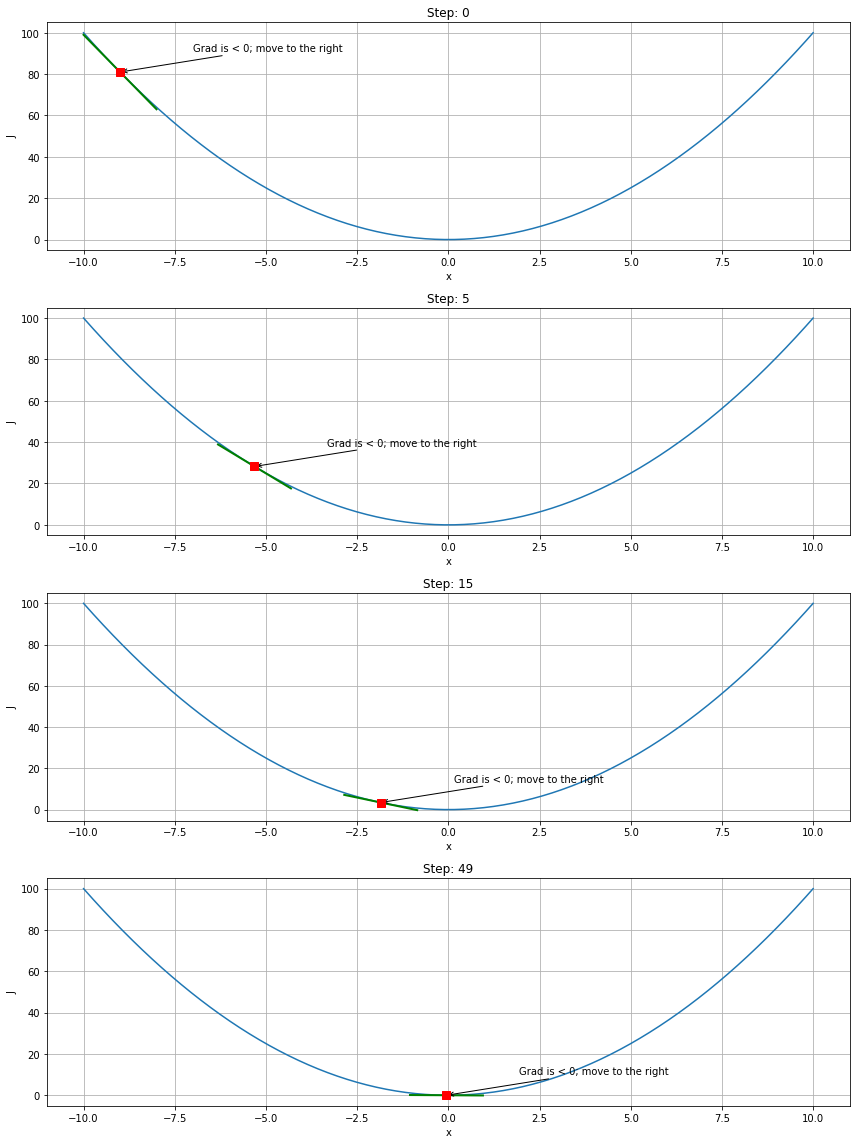

In [3]:
# Starting from the left side
descend(-9.0, 0.05)

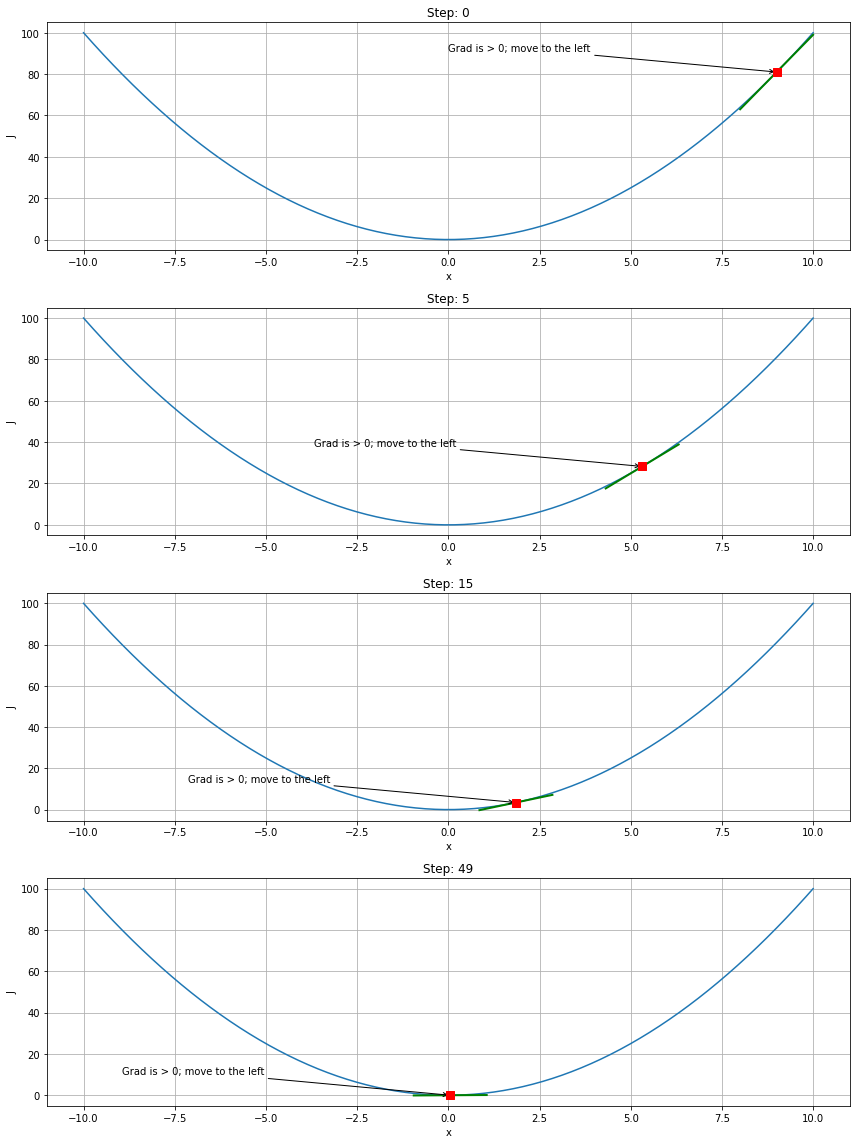

In [4]:
# Starting from the right side
descend(9.0, 0.05)

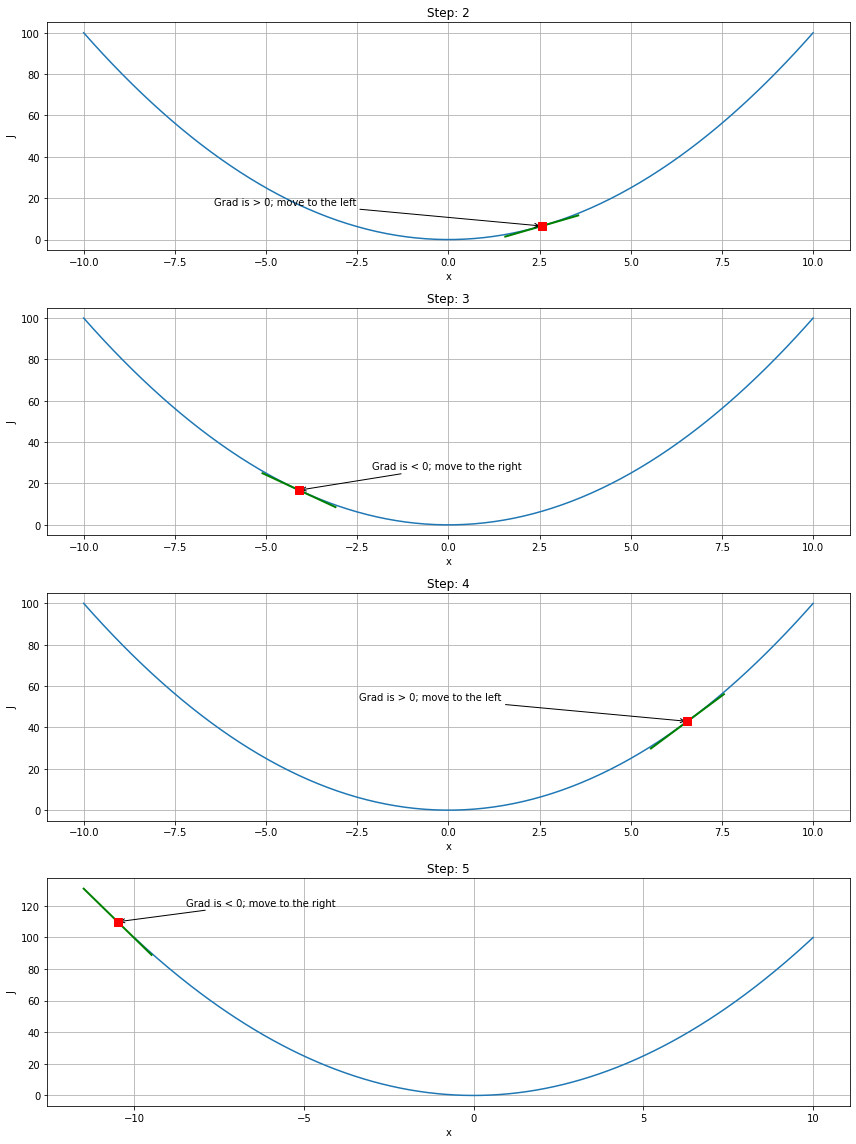

In [5]:
# What happens if learning rate is too high
descend(1.0, 1.3, 6, [2, 3, 4, 5])

# Gradient Descent with TensorFlow

##### Create some toy data

Let's create some data to learn from.  We're going to end up fitting a line to this data using linear regression.  The following code creates scatter data that is roughly along the line $y=3x+2$.  This is in the classing point-slope form of a line $y=mx+b$, but to prepare us for more general formulations, we'll write it as $y=wx+b$ ($w$ for *weight*).

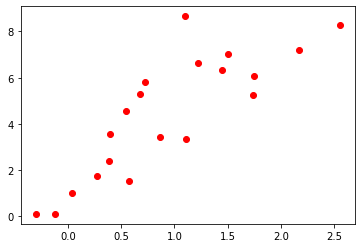

In [6]:
x = np.random.normal(loc=1, scale=1, size=[20])
epsilon = np.random.normal(loc=0, scale=1.5, size=[20])
y = (3 * x) + 2 + epsilon
plt.scatter(x,y,c='r');

Now, we can create a simple linear model that can learn to fit the previous data.  You know the drill by now.  We will:
  1.  Create the model
  2.  Run the model

##### Create Graph for the Linear Regression Model

In [7]:
linreg_graph = tf.Graph()
with linreg_graph.as_default():
    with tf.name_scope('inputs'):
        x_placeholder = tf.placeholder(tf.float32, [None], name='x')
        y_placeholder = tf.placeholder(tf.float32, [None], name='y')
        learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')

    with tf.name_scope('model'):
        w = tf.Variable(tf.truncated_normal([]), name='w')
        b = tf.Variable(tf.constant(0, dtype=tf.float32), name='b')
        y_hat = tf.multiply(w, x_placeholder) + b
    
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.square(y_hat - y_placeholder), name='MSE')
    
    with tf.name_scope('train'):
        opt = tf.train.GradientDescentOptimizer # long name!
        train = opt(learning_rate).minimize(loss)
    
    with tf.name_scope('global_step'):
        global_step = tf.Variable(0, trainable=False, name='global_step')
        inc_step = tf.assign_add(global_step, 1, name='inc_step')
    
    with tf.name_scope('helpers'):
        init = tf.global_variables_initializer()

##### Run the Model

We start off by initializeing the Variables:

In [8]:
session = tf.Session(graph=linreg_graph)
session.run(init)

And now we setup a simple training and testing scenario with some model data.  I've recreated the simulated data below for easy reference.  `train_dict` and `test_dict` will be fed into `run` calls.  They tie our python level data to Tensors in our graph (e.g., (e.g., `x_train` to  `x_placeholder`).

In [9]:
# "true" model:  y = true_w * x + true_b
true_w, true_b = 3,2

# create training data and make a feeder dict
x_train = np.random.uniform(-5, 5, size=[20])
epsilon = np.random.normal(loc=0, scale=1.5, size=[20])
y_train = (true_w * x_train) + true_b + epsilon
train_dict = {x_placeholder: x_train,
              y_placeholder: y_train,
              learning_rate: 0.05}

# some points to evaluate at 
# also serve to reconstruct fitted line below
x_test = np.array([-5.0, 5.0])
test_dict = {x_placeholder: x_test}

And finally, the "main" running of the model.  We have an loop that performs training every pass through.  Then, at selected steps (0, 1, 4, 10, 49), we also keep track of some results of testing on our evaluation `x_test` data.  In the `y_test=` line (line 10), we *do not* fetch the value of the `train` Operation.  Thus, we *do not* update the weights of our model.  Put another way, we only train when we fetch `train`.

In [10]:
snapshots = []
print("{:2} {:^6s}".format("i", "MSE"))
for i in range(50):    
    J, w_est, b_est, step, _ = session.run([loss, w, b, inc_step, train], 
                                           feed_dict=train_dict)
    if not i % 5:
        print("{:<2d} {:>6.3f}".format(step, J))

    if step in [0, 1, 4, 10, 49]:
        y_test = session.run(y_hat, feed_dict=test_dict)
        snapshots.append((i, y_test, w_est, b_est, J))    

i   MSE  
1  105.134
6   3.330
11  2.400
16  2.044
21  1.908
26  1.856
31  1.836
36  1.829
41  1.826
46  1.824


# Visualize the Progression of the Estimates

In [11]:
# Get the final W and b values
final_w_est, final_b_est = session.run([w, b])

# extract out the sequences of w/b/J from the overall snapshots
# PYTHON TRICKERY:  zip(*seq) does the "opposite" of zip()
# here, it essentially pulls out the "columns" of snapshots
_, _, w_ests, b_ests, losses = zip(*snapshots)

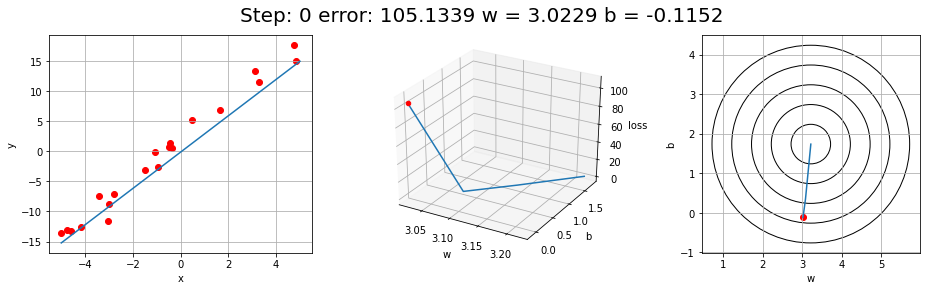

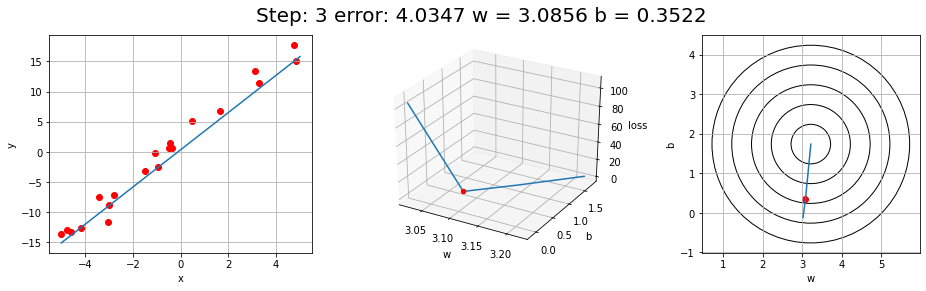

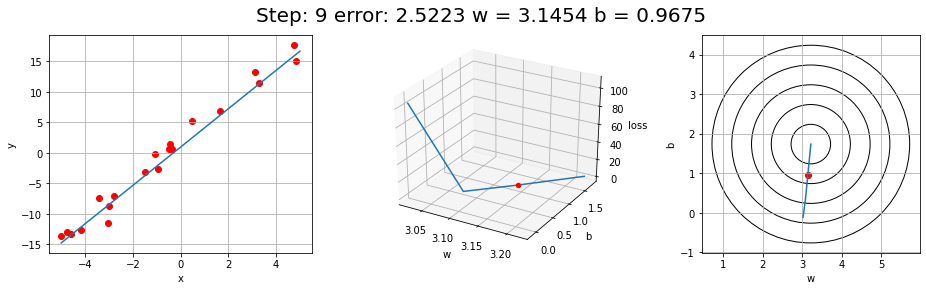

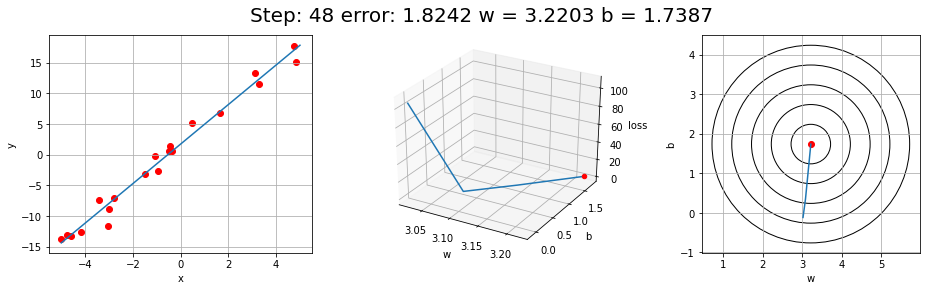

In [12]:
for i, snapshot in enumerate(snapshots):
    # extract needed components for current snapshot
    step, y_test, curr_w_est, curr_b_est, curr_loss = snapshot

    # setup outer figure
    fig = plt.figure(figsize=(16,4))
    title_fmt = 'Step: {} error: {:0.4f} w = {:0.4f} b = {:0.4f}'
    title_string = title_fmt.format(step, curr_loss, 
                                    curr_w_est, curr_b_est)
    fig.suptitle(title_string, size=20)

    # Scatter plot of data with predicted line
    ax = plt.subplot(131)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.grid(True)
    ax.scatter(x_train, y_train, c='r')
    ax.plot(x_test, y_test) # both curr train->test and estimated line

    # 3D view of estimated w and b values against loss
    ax = plt.subplot(132, projection='3d')
    ax.set_xlabel('w'); ax.set_ylabel('b'); ax.set_zlabel('loss')
    ax.plot(w_ests, b_ests, losses)
    ax.scatter(curr_w_est, curr_b_est, curr_loss, c='r')
    
    # Overhead view of approximate error curves
    ax = plt.subplot(133)
    ax.set_xlabel('w'); ax.set_ylabel('b'); ax.grid(True)
    for i in range(1,6):
        circ = mpl.patches.Circle([final_w_est, final_b_est], 
                                  .5 * i, fill=False)
        ax.add_patch(circ)
        
    ax.plot(w_ests, b_ests)                   # the path of w/b estimates
    ax.scatter(curr_w_est, curr_b_est, c='r') # really just one point
    ax.set_aspect('equal')

In [13]:
# scikit learn's estimates
import sklearn.linear_model as sk_lm
model = sk_lm.LinearRegression()
model.fit(np.reshape(x_train,[20,1]), y_train)
print('sk linreg w: {:5.3f} b: {:5.3f}'.format(model.coef_[0], 
                                                model.intercept_))

# compared with our estimates
print('our tflr  w: {:5.3f} b: {:5.3f}'.format(final_w_est, 
                                                final_b_est))

sk linreg w: 3.222 b: 1.757
our tflr  w: 3.220 b: 1.740


# Examining gradients

The below code gets the gradient of the `tf.square()` Operation, which we expect to return `2*input`, as the derivative of $x^2$ is $2x$

In [14]:
grad_graph = tf.Graph()
with grad_graph.as_default():
    # A dummy variable that we can play around with to get different values
    a = tf.Variable(3.0)

    # The operation we want to get the derivative of
    # b = a**2; deriv(b) = deriv(a**2) = 2a 
    # eval @ a=3 gives deriv(b wrt a) = 6
    b = tf.square(a) 

    # Create an Optimizer
    opt = tf.train.GradientDescentOptimizer(0.05)

    # Compute the gradient of `b` with respect to `a`
    grads = opt.compute_gradients(b, [a])
    init = tf.global_variables_initializer()

    
with tf.Session(graph=grad_graph) as session:
    session.run(init)
    print(session.run(grads))

[(6.0, 3.0)]


# Some Realistic Data

We'll use the UCI Housing dataset for this example, where the target is to predict the median value of homes in neighborhoods of Boston. The below code downloads the dataset and information files.

In [15]:
data_dir = 'data'

base_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/'
data_suf = 'housing/housing.{}'
url = base_url + data_suf

data_path = helpers_02.download(url.format('data'), data_dir)
helpers_02.download(url.format('names'), data_dir)

'data/housing.names'

The variables in the dataset are defined in `data/housing.names`.  You can read through that file, but we've extracted the important parts here.

1. **CRIM**: per capita crime rate by town
2. **ZN**: proportion of residential land zoned for lots over 25,000 sq.ft.
3. **INDUS**: proportion of non-retail business acres per town
4. **CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. **NOX**: nitric oxides concentration (parts per 10 million)
6. **RM**: average number of rooms per dwelling
7. **AGE**: proportion of owner-occupied units built prior to 1940
8. **DIS**: weighted distances to five Boston employment centres
9. **RAD**: index of accessibility to radial highways
10. **TAX**: full-value property-tax rate per \$10,000
11. **PTRATIO**: pupil-teacher ratio by town
12. **B**: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. **LSTAT**: \% lower status of the population
14. **MEDV**: Median value of owner-occupied homes in $1000's

Now, we read in the data using Pandas powerful `pd.read_table` function and label the columns with manually extracted column names.

In [16]:
# manually extracted from housing.names
housing_names = ('CRIM,ZN,INDUS,CHAS,NOX,'
                 'RM,AGE,DIS,RAD,TAX,'
                 'PTRATIO,B,LSTAT,MEDV').split(',')

my_data = pd.read_table(data_path, sep='\s+', names=housing_names)

# one way to shuffle the data
# data = data.reindex(np.random.permutation(data.index))
my_data.head()  

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Here is a quick way to make a single train/test split of the overall DataFrame.  This has some benefits over scikit_learn's `train_test_split` because our method does not shuffle the data (skl shuffles the indices and uses fancy indexing to select the train and test sets - this triggers a copy).  The result is that our method doesn't require copies which might be important with bigger datasets.

In [17]:
# why not just use sklearn shuffle split?  
# skl uses fancy indexing which triggers copies
# these are continguous blocks, so there is no copy needed
def df_train_test_blocks(df, pct):
    num_train_examples = int(len(df) * pct)
    return df.iloc[:num_train_examples], df.iloc[num_train_examples:]
my_train, my_test = df_train_test_blocks(my_data, .8)
my_train.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
399,9.91655,0.0,18.1,0,0.693,5.852,77.8,1.5004,24,666.0,20.2,338.16,29.97,6.3
400,25.04610,0.0,18.1,0,0.693,5.987,100.0,1.5888,24,666.0,20.2,396.90,26.77,5.6
401,14.23620,0.0,18.1,0,0.693,6.343,100.0,1.5741,24,666.0,20.2,396.90,20.32,7.2
402,9.59571,0.0,18.1,0,0.693,6.404,100.0,1.6390,24,666.0,20.2,376.11,20.31,12.1
403,24.80170,0.0,18.1,0,0.693,5.349,96.0,1.7028,24,666.0,20.2,396.90,19.77,8.3


Now that we have some more realistic data and we've created train/test subsets of the data, let's do some (linear regression) modeling!  Let's pick a few features (number of rooms, age, and tax rate) and (1) look at some descriptive statistics for those features and (2) look at the pairwise interactions between those features and median value with some scatter plots.  These graphs are only for the training data!

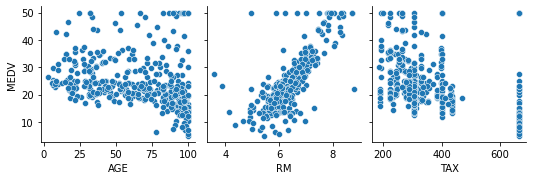

In [18]:
my_ftrs = my_train[['MEDV', 'AGE', 'RM', 'TAX']]
my_ftrs.describe()

import seaborn as sns
sns.pairplot(my_ftrs, x_vars=['AGE', 'RM', 'TAX'], y_vars=['MEDV']);

# Linear Regression Models with `scikit_learn`

In [19]:
# models:  price ~ age, price ~ rooms, price ~ tax
# scatter, regression line, r^2
# more models:  saturated (all), price ~ rooms + tax

Let's make three regression models between these variables (individually) and median price.  So, our three models will be (where $y \sim x$ is read as "y is modeled on x", this notation comes from R): 
  1. $price \sim  age$
  1. $price \sim rooms$
  3. $price \sim tax$
  
In turn, we'll use the training data to build each of these models (using scikit_learn) and then we'll graph the fit line against the training data.  We'll also compute the $R^2$ statistic for the fit against the training data ($R^2$ is SKL's default scorer for LinearRegression).

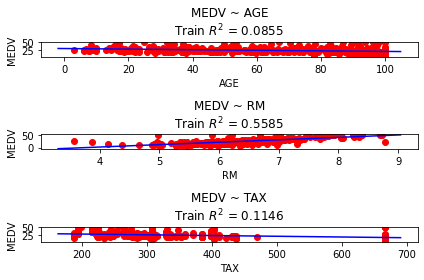

In [20]:
model_on = ['AGE', 'RM', 'TAX']
models = {}
fig, axes = plt.subplots(3,1)
for ax, ftr in zip(axes, model_on):
    models[ftr] = sk_lm.LinearRegression().fit(my_ftrs[[ftr]], 
                                               my_ftrs[['MEDV']])
    ax.scatter(my_ftrs[[ftr]], my_ftrs[['MEDV']], c='r')

    x_vals = np.array(ax.get_xlim()) # great trick to get min/max x
    y_vals = models[ftr].intercept_ + models[ftr].coef_[0] * x_vals
    ax.plot(x_vals, y_vals, c='b')

    train_r_squared = models[ftr].score(my_ftrs[[ftr]], 
                                       my_ftrs[['MEDV']])
    
    ax.set_xlabel(ftr); ax.set_ylabel('MEDV')
    ax.set_title("MEDV ~ {}\nTrain $R^2$ = {:5.4f}".format(ftr, train_r_squared))

plt.tight_layout()

Now, typically, we don't expect single variable to fully capture complex phenomena. So, let's build two more models:
  
  1. $price \sim age + room + tax$
  2. $price \sim room + tax$
  
Here, adding something to the right hand side of the model means it is an additional feature/variable in our model.

In [21]:
models = (('Full', ['AGE', 'RM', 'TAX']),
          ('Room, Tax', ['RM', 'TAX']))
target = 'MEDV'

for model_name, predictors in models:
    fit = sk_lm.LinearRegression().fit(my_ftrs[predictors],
                                       my_ftrs[target])
    r2 = fit.score(my_ftrs[predictors], my_ftrs[target])
    print("{:10} Train R^2: {:5.4f}".format(model_name, r2))

Full       Train R^2: 0.5780
Room, Tax  Train R^2: 0.5717


# Housing Data Modeling with TensorFlow

The room and tax model seems to do fairly well (at least compared to all three variables).  So, let's recreate that with TensorFlow.  We are going to add one layer of abstraction to our model.  You'll notice that the scikit_learn `Linear Regression` has three steps:

  1.  create it
  2.  fit it
  3.  predict/score with it
  
These are very similar to the way we will typically use a TensorFlow model.  We've had two types of *running* our models that correspond to the fit and predict (train and test) steps for scikit learn.  The way we will implement this (and simplify the code that *uses* our model) is by create a simple `class` which has three methods:

  1. `__init__`:  create the TensorFlow Graph
  2. `fit`:  read in training data and optimize to it
  3. `predict`:  read in testing data and give our best guesses (and possibly other results)

In [22]:
class TF_GD_LinearRegression:
    # WARNING: 
    # s instead of self is non-standard, for abbreviation purposes
    def __init__(s):  
        graph = tf.Graph()
        with graph.as_default():
            with tf.name_scope('inputs'):
                s.x_placeholder = tf.placeholder(tf.float32, 
                                                 [None, 2], name='x')
                s.y_placeholder = tf.placeholder(tf.float32, 
                                                 [None], name='y')
                s.learning_rate = tf.placeholder(tf.float32, 
                                                 [], name='learning_rate')
            with tf.name_scope('model'):
                s.w = tf.Variable(tf.truncated_normal([2, 1]), name='w')
                s.b = tf.Variable(0.0, name='b')
                s.y_hat = tf.matmul(s.x_placeholder, s.w) + s.b
            
            with tf.name_scope('loss'):
                s.loss = tf.reduce_mean(tf.square(s.y_hat - s.y_placeholder), name='MSE')
            
            with tf.name_scope('train'):
                s.train = tf.train.GradientDescentOptimizer(s.learning_rate).minimize(s.loss)
            
            s.init = tf.global_variables_initializer()
        s.session = tf.Session(graph=graph)
        s.session.run(s.init)
    
    def fit(s, train_dict):
        return s.session.run([s.loss, s.w, s.b, s.train], feed_dict=train_dict)

    def predict(s, test_dict):
        return s.session.run(s.y_hat, feed_dict=test_dict)

There are at least three major advantages to structuring our code in a class:
  1.  We have clearly delineated what the capabilities of the code are:  creation, fit, and prediction.
  2.  Instead of "polluting" our top-level code (our main program) with many model Tensors, they are all contained within the class.  If we *must* access them in the main program, we can always access them with `object.Tensor` (there's an example coming below when we create the training and testing dictionaries).
  3.  Although we don't do it here, if we needed to make many "same but different" models, we could use the same structure to create the models and passing in parameters to control the differences.
  
Enough talk.  Let's do this thing.

In [23]:
# read in the data (just a reminder from what was above)
print("Data file:", data_path)
print("Names:", housing_names)
my_data = pd.read_table(data_path, sep='\s+', names=housing_names)

# select out some columns of interest and then train/test split it
my_ftrs = my_data[['MEDV', 'AGE', 'RM', 'TAX']]
my_train, my_test = df_train_test_blocks(my_ftrs, .8)

# our ftrs to use for this particular model
predictors = ['RM', 'TAX']
target     = 'MEDV' # output tensor (y_placeholder) expects 1D tensor, not 2D - so no list

# feeding data to TensorFlow, might not be happy with DataFrames
# so we access the underlying NumPy data directly with .values
my_train_x = my_train[predictors].values
my_train_y = my_train[target].values
my_test_x  = my_test[predictors].values
my_test_y  = my_test[target].values

Data file: data/housing.data
Names: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']


In [24]:
model = TF_GD_LinearRegression()

# model.x_placeholder becomes s.x_placeholder in TF_GD_LinearRegression above
train_dict = {model.x_placeholder: my_train_x,
              model.y_placeholder: my_train_y,
              model.learning_rate: 0.000001}

test_dict = {model.x_placeholder: my_test_x}

In [25]:
print("{:3} {:>15s}".format("i", "Training MSE"))
snapshots = []

for epoch in range(1000):
    loss, w, b, _ = model.fit(train_dict)
    if epoch % 100 == 0 or epoch < 10:
        print("{:<3d} {:>15.3f}".format(epoch, loss))
        y_test = model.predict(test_dict)
        snapshots.append((epoch, y_test, w, b, loss))
print("{:<2d} {:>15.3f}".format(epoch, loss))

i      Training MSE
0        383807.938
1        197023.938
2        101185.008
3         52010.031
4         26778.338
5         13831.949
6          7189.148
7          3780.725
8          2031.861
9          1134.517
100         188.659
200         188.407
300         188.155
400         187.904
500         187.654
600         187.404
700         187.155
800         186.907
900         186.659
999         186.414


Let's take the final trained model and use it to make predictions on our test set.  We'll then evaluate the quality of those predictions.  For ease of comparison, we'll compute the MSE (mean squared error) and use that as our metric.  You might like to play around with adding more iterations (epochs) to the training phase above and see how many iterations it takes to match scikit_learn's performance.  As an estimate, 100,000 epochs was getting closer to scikit learn's level, but didn't match it.

In [26]:
# final trained model
import sklearn.metrics as sk_metrics
y_test = model.predict(test_dict)
tf_roomtax_mse = sk_metrics.mean_squared_error(y_test[:,0], my_test_y)

print("tensorflow gd linear regression model")
print("price ~ room + tax")
print("w: {} b: {}".format(w[:,0],b))
print("Test MSE:", tf_roomtax_mse)

tensorflow gd linear regression model
price ~ room + tax
w: [-0.6604683   0.07043204] b: 0.0029490673914551735
Test MSE: 696.3087719372248


In [27]:
# and for comparison, with the scikit learn room+tax model
skl_fit = sk_lm.LinearRegression().fit(my_train_x, my_train_y)
skl_roomtax_mse = sk_metrics.mean_squared_error(skl_fit.predict(my_test_x), my_test_y)

print("sklearn linear regression model:")
print("price ~ room + tax")
print("w: {} b: {}".format(skl_fit.coef_, skl_fit.intercept_))
print("Test MSE: {}".format(skl_roomtax_mse))

sklearn linear regression model:
price ~ room + tax
w: [ 8.98769653e+00 -8.49948244e-03] b: -29.74475851203423
Test MSE: 49.08609999001699


# Exercises

##### Part 1: Access the Wine Quality Data

Using `helpers_02.download` and the URL shown in a second, grab the [UCI Wine Quality data set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality).  We are only going to focus on the white wines, but you are free to grab both files.  The wine quality data files live at:
  
  * https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
  * https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

There is also a `winequality.names` file in that directory.  You should be able to use the `base_url` that we defined earlier to assist you in creating a url for the `download` function.

##### Part 2:  Load the Data with Pandas

Read the data into a DataFrame with Pandas.  `pd.read_csv` would be very useful here.  Note, it has an option to specify the delimiter (and the wine csv files are not comma separated).  One other note, you should specify a `dtype` to `read_csv`:  the quality value in the dataset is given as an integer, but our model (a regression model) is expecting a float value.

##### Part 3:  Create a Train-Validation-Split Function

In some instances (for example, when we need to set "hyperparameters" which are not optimized by our Graph), we may want a separate validation set.  Using `df_train_test_blocks` as a model, create `df_train_valid_test_blocks` which splits the data into three contiguous subsets.  As a reminder, if you wanted this splitting to be randomized, you would shuffle everything first and *then* split it.

Create `x_train`, `x_test`, `y_train`, and `y_test`.  Feel free to choose whatever predictors you would like.  However, make it interesting, choose at least four or more.  You might like to go to all.  Doing that conveniently requires a bit of Pandas-fu.  If you struggle, feel free to look at the solutions - this isn't a Pandas test!

##### Part 4:  Create a Multivariate Linear Model in TensorFlow

Create a Linear Regression model that is appropriate for the training data you selected out. Using `TF_GD_LinearRegression` will get you started, and in fact, it will get you almost all of the way there.  The model we constructed above was designed for two (and only two) predictors.  You will need to change it to accept more predictors.  [Hint:  there are *two* values in the Graph creation process you need to adjust.]

If you are feeling up to it, you can make that modification a parameter to `__init__` so you can easily create models for different numbers of predictors.

##### Part 5:  Train and Test your Model

'nuff said.  Try different learning rates and numbers of epochs.  Consider using different subsets of predictors.  See how well you can do (in terms of minimizing your test MSE).  You might want to compare your results with scikit learn.

##### Part 6: Details, Details
Finally, add some TensorBoard features to your Linear Regression model.

* Add a scalar summary for your loss
* Open up a FileWriter to save summaries to disk
* Periodically write summary data to disk

## Solutions

##### Part 1

##### Part 2

##### Part 3

We don't have any hyperparameters, so I'm going to save data and not make a validation set.

##### Part 4

##### Part 5

##### Part 6